In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
match_df = pd.read_csv(r"..\dataset\processed_data_1\match_df_20_24_symmetry.csv",low_memory=False)

In [3]:
match_df= match_df.dropna()

In [4]:
print(match_df.columns.tolist())

['tourney_id', 'tourney_date', 'round_code', 'best_of', 'surface_Clay', 'surface_Grass', 'surface_Hard', 'player1_id', 'player2_id', 'result', 'sym_index', 'sym_seed_bucket', 'sym_entry', 'sym_host', 'sym_hand', 'sym_ht', 'sym_age', 'sym_rank', 'sym_rank_points', 'sym_elo', 'sym_ace', 'sym_df', 'sym_svpt', 'sym_fstIn', 'sym_fstWon', 'sym_sndWon', 'sym_SvGms', 'sym_bpSaved', 'sym_bpFaced', 'sym_ace_rate', 'sym_df_rate', 'sym_serve_win_rate', 'sym_serve_efficiency', 'sym_clutch_ability', 'sym_o_seed_bucket', 'sym_o_entry', 'sym_o_host', 'sym_o_hand', 'sym_o_ht', 'sym_o_age', 'sym_o_rank', 'sym_o_rank_points', 'sym_o_ace', 'sym_o_df', 'sym_o_svpt', 'sym_o_fstIn', 'sym_o_fstWon', 'sym_o_sndWon', 'sym_o_SvGms', 'sym_o_bpSaved', 'sym_o_bpFaced', 'sym_o_ace_rate', 'sym_o_df_rate', 'sym_o_serve_win_rate', 'sym_o_serve_efficiency', 'sym_o_clutch_ability', 'sym_o_sets', 'sym_o_games', 'sym_o_elo', 'sym_ace_hist', 'sym_df_hist', 'sym_svpt_hist', 'sym_fstIn_hist', 'sym_fstWon_hist', 'sym_sndWon_hi

In [30]:
hist_features = [col for col in match_df.columns if col.endswith('_hist')]
hist_e_features = [col for col in match_df.columns if col.endswith('_hist_e')]
histo_features = [col for col in match_df.columns if col.endswith('_histo')]
elo_features = ['sym_elo']
rank_features = [ 'sym_rank', 'sym_rank_points']
supplement_features = ['round_code', 'best_of', 'surface_Clay', 'surface_Grass',
                       'surface_Hard','sym_seed_bucket',
                       'sym_entry', 'sym_host', 'sym_hand', 'sym_ht', 'sym_age']

features = hist_features + hist_e_features + histo_features + elo_features + rank_features + supplement_features
continuous_features = hist_features + hist_e_features + histo_features + elo_features + rank_features + [
    'sym_ht', 'sym_age']
X = match_df[features]
y = match_df['result']

In [31]:
# 显式创建 X 的副本，防止 SettingWithCopyWarning
X = match_df[features].copy()

# 归一化数值特征
scaler = StandardScaler()
X[continuous_features] = scaler.fit_transform(X[continuous_features])

In [7]:
#X = pd.get_dummies(X, columns=['sym_entry', 'sym_hand', 'sym_host','round_code', 'best_of','sym_seed_bucket'], drop_first=True)

match_df['year'] = pd.to_datetime(match_df['tourney_date'], format='%Y-%m-%d').dt.year
train_mask = match_df['year'].between(2020, 2023)
test_mask = (match_df['year'] == 2024)

X_train, X_test = X[train_mask], X[test_mask]
y = match_df['result']
y_train = y[train_mask]
y_test = y[test_mask]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
#按时序年份训练
match_df['year'] = pd.to_datetime(match_df['tourney_date'], format='%Y-%m-%d').dt.year
train_mask = match_df['year'].between(2020, 2023)
test_mask = (match_df['year'] == 2024)

X_train, X_test = X[train_mask], X[test_mask]
y = match_df['result']
y_train = y[train_mask]
y_test = y[test_mask]

In [14]:
#时序交叉验证
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [18]:
# 计算特征与年份的相关性
year_corr = pd.DataFrame({
    'feature': X.columns,
    'corr_with_year': [np.corrcoef(X[col], match_df['year'])[0,1] for col in X.columns]
})

# 筛选时序敏感特征（|相关性|>0.3）
dynamic_features = year_corr[abs(year_corr['corr_with_year']) > 0.3]['feature'].tolist()

In [33]:
model = LogisticRegression(solver='liblinear', penalty='l2', C=0.01)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # 概率预测

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f'Accuracy: {accuracy:.4f}')
print(f'AUC: {auc:.4f}')
print(classification_report(y_test, y_pred))


Accuracy: 0.6710
AUC: 0.7384
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1269
           1       0.65      0.66      0.66      1166

    accuracy                           0.67      2435
   macro avg       0.67      0.67      0.67      2435
weighted avg       0.67      0.67      0.67      2435



In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f'Best C: {grid_search.best_params_["C"]}')


Best C: 10


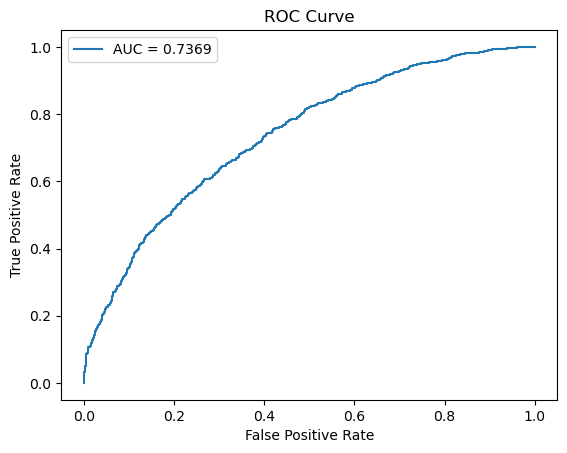

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [26]:
#按年份分层
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# 创建年份特征
match_df['year'] = pd.to_datetime(match_df['tourney_date']).dt.year

# 按年份分层抽样划分数据集（所有年份统一划分）
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.3,  # 修改测试集比例
    stratify=match_df['year'],  # 关键修改点：按年份分层
    random_state=42
)

# 训练全局模型
model = LogisticRegression(solver='liblinear', penalty='l2', C=0.01)
model.fit(X_train, y_train)

# 获取测试集的年份信息
test_indices = y_test.index
test_years = match_df.loc[test_indices, 'year']

# 初始化结果存储
results = {}

# 分年度评估模型表现
for year in test_years.unique():
    # 提取该年份的测试样本
    year_mask = (test_years == year)
    X_year = X_test[year_mask]
    y_year = y_test[year_mask]
    
    # 预测与评估
    y_pred = model.predict(X_year)
    y_prob = model.predict_proba(X_year)[:, 1]
    
    # 存储结果
    results[year] = {
        'accuracy': accuracy_score(y_year, y_pred),
        'auc': roc_auc_score(y_year, y_prob),
        'support': len(y_year),
        'report': classification_report(y_year, y_pred, output_dict=True)
    }

# 打印格式化结果
print(f"Global Test Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}")
print("\nYearly Performance Breakdown:")
for year, metrics in sorted(results.items()):
    print(f"Year {year} (n={metrics['support']}):")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  AUC: {metrics['auc']:.4f}")
    print(f"  F1-score: {metrics['report']['macro avg']['f1-score']:.4f}")

Global Test Accuracy: 0.6542

Yearly Performance Breakdown:
Year 2020 (n=413):
  Accuracy: 0.6634
  AUC: 0.7192
  F1-score: 0.6634
Year 2021 (n=762):
  Accuracy: 0.6457
  AUC: 0.7109
  F1-score: 0.6430
Year 2022 (n=797):
  Accuracy: 0.6625
  AUC: 0.7250
  F1-score: 0.6625
Year 2023 (n=820):
  Accuracy: 0.6634
  AUC: 0.7294
  F1-score: 0.6630
Year 2024 (n=860):
  Accuracy: 0.6407
  AUC: 0.7245
  F1-score: 0.6403


In [35]:
from sklearn.inspection import permutation_importance
import statsmodels.api as sm
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 方法1：系数绝对值
coef_importance = np.abs(model.coef_[0])

# 方法2：置换重要性
perm_result = permutation_importance(
    model, X_test, y_test, n_repeats=30, random_state=42
)
perm_importance = perm_result.importances_mean

In [36]:
importance_df = pd.DataFrame({
    "feature": X.columns,
    "coef_importance": coef_importance,
    "perm_importance": perm_importance,
})

In [37]:
# 按 coef_importance 降序排序（从高到低）
importance_df_sorted = importance_df.sort_values(
    by="coef_importance",     # 指定排序依据的列
    ascending=False,           # 降序排列（值越大越靠前）
)

# 输出排序后的 DataFrame
print(importance_df_sorted)

                         feature  coef_importance  perm_importance
70                       sym_age         0.355684         0.037139
59               sym_rank_points         0.333805         0.018371
58                      sym_rank         0.226912         0.013484
57                       sym_elo         0.223750         0.006379
39       sym_o_rank_points_histo         0.162867         0.008090
54               sym_o_elo_histo         0.116645         0.002916
51    sym_o_serve_win_rate_histo         0.104600         0.002697
66                     sym_entry         0.102206         0.004025
13       sym_serve_win_rate_hist         0.090843         0.003162
29     sym_serve_win_rate_hist_e         0.078585         0.003751
38              sym_o_rank_histo         0.075377         0.001123
25     sym_baseline_rally_hist_e         0.065996        -0.000205
7               sym_bpSaved_hist         0.065704         0.000424
28            sym_df_rate_hist_e         0.065333         0.00